# Data science Project

## Intro

In this project we going to explor data about ELAL's flight history.
The perpose is to explor if we can to predict if ELAL's flight will delayd or canceld



### Imports

In [632]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import seaborn as sns
import os
import time
from time import sleep
from dateutil.relativedelta import relativedelta, MO
from dateutil.easter import easter
import jewish
import calendar
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn import metrics
%matplotlib inline  
# Credit to https://github.com/emosenkis/jewish/blob/master/LICENSE

### Const Varibles

In [633]:
BASE_URL='https://api.flightstats.com/flex/flightstatus/historical/rest/v3/json/'


# APP_KEY='1073eea843b49ef65cd3dedce57340e0'
# APP_ID='a55ccedd'

# APP_KEY='9981b617cba5bb3f32d90ba0da4e2af4'
# APP_ID='65c679ae'

# APP_KEY= '9fb822148287f2805212cc61c199d8f8'
# APP_ID = 'd7585437'

# APP_KEY = 'eca188e5f3d730ee5d28907112889342'
# APP_ID = '4176580c'

# APP_KEY = '37512902d28a8deac5ec0325e9f40a56'
# APP_ID = 'bfeb4319'

APP_KEY = '838de104ed9b72554e810d417ec8f528'
APP_ID = '62e0f779'

ElAl_AIRCRAFTS_WEB_URL = 'https://www.elal.com/heb/about-elal/our-fleet/all-aircraft'
FLIGHTEAR_Base_URL = 'https://www.flightera.net/en/planes/'

AIRCRAFTS_DATA_FILE = 'aircrafts.json'
FLIGHT_Data_FILE = 'flights_data.json'
FLIGHTS_SCAN_METADATA_FILE = 'flights_scan_metadata.json'

TAIL_NUMBER_FEILD_NAME = 'tail_number'
FIRST_FLIGHT_DATE_FEILD_NAME = 'first_flight_date'
LAST_FLIGHT_DATE_FEILD_NAME = 'last-flight_date'
SEATS_FEILD_NAME = 'seats'
LAST_SCANNED__DATE_FEILD_NAME = 'last_scanned_date'


## General files and json functions

Functions that store and loads data from files

In [634]:
def store_object_to_file(file_name,data):
    with open(file_name, 'w') as outfile:
        json.dump(data, outfile)

In [635]:
def load_object_from_file(filename):
    if(not os.path.exists(filename)):
        return None
    with open(filename) as f:
        return json.load(f)

In [636]:
def store_data_to_aircrafts_file(tailnumber,feild_name,data):
    aircrafts_list = load_object_from_file(AIRCRAFTS_DATA_FILE)
    if(not aircrafts_list):
        aircrafts_list = []
    for i,aircraft in enumerate(aircrafts_list):
        if(tailnumber == aircraft[TAIL_NUMBER_FEILD_NAME]):
            aircrafts_list[i][feild_name] = data
            store_object_to_file(AIRCRAFTS_DATA_FILE,aircrafts_list)
            return

In [637]:
def load_data_from_aircrafts_file(tailnumber,feild_name):
    if(not os.path.exists(AIRCRAFTS_DATA_FILE)):
        return None
    aircrafts_list = load_object_from_file(AIRCRAFTS_DATA_FILE)
    for aircraft in aircrafts_list:
        if(tailnumber == aircraft[TAIL_NUMBER_FEILD_NAME]):
            if feild_name in aircraft:
                return aircraft[feild_name]
            else:
                return None

## Dates and holidays calculations

Mounths dictianery used to translate month name to numbrr

In [638]:
months = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }


Check if some date is crestian holiday

In [639]:
def is_christian_holiday(date):
    easter_date = easter(date.year)
    easter_sunday = datetime.strptime(easter_date.strftime('%m/%d/%Y'), '%m/%d/%Y').date()
    easter_monday = easter_sunday + relativedelta(weekday=MO)
    good_friday = easter_sunday - relativedelta(days=2)
    christmas_day = datetime(year=date.year, month=12, day=25).date()
    holidays = [easter_sunday, easter_monday, good_friday, christmas_day]
    return int(date in holidays)

In [640]:
def is_jewish_holiday(date):
    jewish_date = jewish.JewishDate.from_date(date)

    #rosh hashana
    if(jewish_date.day == 1 and jewish_date.month == 1): return 1
    #yom kipur
    if(jewish_date.day == 10 and jewish_date.month == 1): return 1
    #sukot
    if(jewish_date.month == 1 and (jewish_date.day >= 16 and jewish_date.day <= 21)): return 1
    #hanuka
    if(jewish_date.month == 3 and (jewish_date.day >= 23 and jewish_date.day <= 29)): return 1
    #passover
    if(jewish_date.month == 7 and (jewish_date.day >= 14 and jewish_date.day <= 22)): return 1

    return 0



### API functions

In [641]:
# "BASE URL + flight/status/tailNumber/4x-ELA/2015/1/1?appId=b1aa7a60&appKey=ed14bb251c167a18733cccbf86105175"

def get_Flight_by_date_and_tail_number(date,tail_number, days_per_request):
    formatted_date = date.strftime("%Y/%m/%d")

    #URL = BASE_URL + 'flight/status/tailNumber/' + tail_number + '/' + formatted_date + '?appId=' + APP_KEY + '&appKey=' + API_KEY
    URL = BASE_URL+'flight/status/tailNumber/'+tail_number+'/'+formatted_date+'?appId='+APP_ID+'&appKey='+APP_KEY+'&numDays=30'#+str(days_per_request)
    response = requests.get(URL)
    json_res =  response.json()
    if 'flightStatuses' in json_res: return json_res['flightStatuses'] , None
    if('error' in json_res): return None , json_res['error']
    return None, json_res[0]


test the api

In [642]:
# res = get_Flight_by_date_and_tail_number(datetime(2017,9,28),'4X-EDA',days_per_request=30)
# res

## Get information that we need before start to send api requests

To send this API request we have to know the aircradt tail number
we will get this informaition from elal web side via crouling

In [643]:
elal_web_res = requests.get(ElAl_AIRCRAFTS_WEB_URL)

In [644]:

elal_soup = BeautifulSoup(elal_web_res.content)

Define functios that clean the data


The format of right israeli tail number is '4X-' and 3 letters
like: '$X-ABC'

In [645]:
def clean_tail_numberst(tail_number):
    tail_number = tail_number.upper()
    first_instance_of_4x = tail_number.find('4X-')
    new_tail_number = tail_number[first_instance_of_4x:first_instance_of_4x+6]
    return new_tail_number



In [646]:
def clean_aircraft_name(name):
    return str(name.replace('\u200b',''))

In [647]:
def clean_model(model):
    model = model.strip()
    return model[3:]

Define function that return list of aircraft with ther usefull data

In [648]:
def get_basic_aircrafts_data_list():
    if(os.path.exists(AIRCRAFTS_DATA_FILE)):
        return load_object_from_file(AIRCRAFTS_DATA_FILE)
    
    aircrafts_list=[]
    tables_list = elal_soup.find_all('tbody')
    headers_list = elal_soup.find_all('span',class_ = 'mat-content')
    for j,table in enumerate(tables_list):
        rows_list = table.findAll('tr')
        for row in rows_list[1:]:
            cells_list = row.findAll('td')
            for i,cell in enumerate(cells_list[1::2]):
                aircraft_object = {}
                aircraft_object['tail_number'] = clean_tail_numberst(cell.get_text())
                aircraft_object['model'] = clean_model(headers_list[j].get_text())
                aircraft_object['name'] = clean_aircraft_name(cells_list[i].get_text())
                aircrafts_list.append(aircraft_object) 

    if (not os.path.exists(AIRCRAFTS_DATA_FILE)):
        store_object_to_file(AIRCRAFTS_DATA_FILE,aircrafts_list)   
    return aircrafts_list

#basic_data



### Get more Advanced information about aircraft that not exost in ELAL website 

this dictianery store soap object about each aircraft
it use to lower the http get request to flightera website becaue it will block us if we try to request each time we want more information about the same aircraft

In [649]:
flightEra_soaps_dict = {}

Define function that get flightera soap object of spesific air craft

if we also have soap object about this aircraft in the dict we just need to return it
else, we create http request, convert it to soap object and store it to the dist. then return it

In [650]:
def get_flghtera_soap_by_tail_number(tail_number): 
    if (tail_number.lower() not in flightEra_soaps_dict):       
        URL = FLIGHTEAR_Base_URL + tail_number
        flightera_response = requests.get(URL)
        if (not flightera_response.status_code == 200):
            print('Error resived data about '+tail_number+' from FLightera web sit, error code: ' + str(flightera_response.status_code))
            return None
        flightEra_soaps_dict[tail_number] =  BeautifulSoup(flightera_response.content)
    
    return flightEra_soaps_dict[tail_number]

In [651]:
x = get_flghtera_soap_by_tail_number('4x-elk')
x

Error resived data about 4x-elk from FLightera web sit, error code: 403


## Get first  and last filght date

we neet to get the first time that specific aircrat fly.
this information help us to reduse the api request we need to do because eithout it we will need to create requests for evwry day in pre known dates range and if we know the first and last flights date of the aircraft we can short the dates range

### Get first flight date

In [652]:
def get_first_flight_date_from_Cache(tail_number):
    return load_data_from_aircrafts_file(tail_number,FIRST_FLIGHT_DATE_FEILD_NAME)

In [653]:
def store_first_flight_date_data(tail_number,first_flight_date):
    store_data_to_aircrafts_file(tail_number,FIRST_FLIGHT_DATE_FEILD_NAME,first_flight_date)

In [654]:
def clean_first_flight_dtate_string(date_str):
    clean_str = date_str.replace('\n', '')
    clean_str = clean_str.strip()
    clean_str = clean_str[:clean_str.find('(')]
    clean_str = clean_str.strip()
    return clean_str

In [655]:
def convert_daytime_to_dict(date):
    if (date == None):
         return None
    return {
        'year' : date.year,
        'month' : date.month,
        'day' : date.day
    }

In [656]:
def get_first_flight_date_by_crowling(tail_number):
    aircraft_soap = get_flghtera_soap_by_tail_number(tail_number.lower())
    if(not aircraft_soap): 
        return None
    try:
        for td in aircraft_soap.find_all('td'):
            if(td.get_text().find('years ago') != -1):
                date_string = td.get_text()
        date_string = clean_first_flight_dtate_string(date_string)
        month , year = date_string.split(' ')
        return convert_daytime_to_dict(datetime(int(year),int(months[month.lower()]),27))
    except:
        return None
    return None

In [657]:
def get_first_flight_date_by_tailnnumber(tail_number):
    cashed_data = get_first_flight_date_from_Cache(tail_number)
    
    if(cashed_data):
        return cashed_data
    else: 
        first_flight_date_data = get_first_flight_date_by_crowling(tail_number)
        if(first_flight_date_data):
            store_first_flight_date_data(tail_number,first_flight_date_data)
            return first_flight_date_data
        return None

### Get Last flight date

In [658]:
def get_last_flight_date_from_Cache(tail_number):
    return load_data_from_aircrafts_file(tail_number,LAST_FLIGHT_DATE_FEILD_NAME)

In [659]:
def store_last_flight_date_data(tail_number,last_flight_date):
    store_data_to_aircrafts_file(tail_number,LAST_FLIGHT_DATE_FEILD_NAME,last_flight_date)

In [660]:
def clean_last_flight_month(mnt):
    mnt = mnt.replace('\t','')
    mnt = mnt.strip()
    mnt = mnt[:3]
    return mnt.lower()

In [661]:
def get_last_flight_date_by_crowling(tail_number):
    aircraft_soap = get_flghtera_soap_by_tail_number(tail_number.lower())
    if(not aircraft_soap): return None
    try:
        year = int(aircraft_soap.find('body').find_all('div',class_='sm:px-6')[4].find_all('dt')[0].get_text())
        month = aircraft_soap.find('body').find_all('div',class_='sm:px-6')[4].find_all('dl')[0].find_all('dd')[0].find_all('div')[0].get_text()
        month = clean_last_flight_month(month)
        
        last_flight_date = datetime(year,months[month],1)
        return convert_daytime_to_dict(last_flight_date)
    except:
        return None
    return None

In [662]:
def get_last_flight_date_by_tailnnumber(tail_number):
    cashed_data = get_last_flight_date_from_Cache(tail_number)
    if(cashed_data): return cashed_data
    else: 
        last_flight_date_data = get_last_flight_date_by_crowling(tail_number)
        if(last_flight_date_data):
            store_last_flight_date_data(tail_number,last_flight_date_data)
            return last_flight_date_data
        return None

## Get number of seats per aircraft

this information can be usefull to predict the dilay time of flight

In [663]:
def store_seats_data(tail_number,seats_object):
    store_data_to_aircrafts_file(tail_number,SEATS_FEILD_NAME,seats_object)

In [664]:
def get_seats_from_Cache(tail_number):
    return load_data_from_aircrafts_file(tail_number,SEATS_FEILD_NAME)

In [665]:
def get_seats_by_crowling(tail_number):
    aircraft_soap = get_flghtera_soap_by_tail_number(tail_number.lower())
    aircraft_seat_object = {}
    strings = []
    try:
        for td in aircraft_soap.find_all('td'):
            if(td.get_text().find('seats') != -1):
                strings = td.get_text().split('\n')
                
    except:
        return None
    i=0
    for i,s in enumerate(strings):
        if(s.find('seats') != -1):
            break
    for content in strings[i+1:-1]:
        seat , class_ = content.split(' ')
        aircraft_seat_object[class_] = str(seat)
        print(aircraft_seat_object)

    return aircraft_seat_object
    

In [666]:
def get_seats_by_tail_number(tail_number):
    cashed_data = get_seats_from_Cache(tail_number)
    if(cashed_data): return cashed_data
    else: 
        seats_data = get_seats_by_crowling(tail_number)
        if(seats_data):
            store_seats_data(tail_number,seats_data)
            return seats_data
        return None
        

### Last scanned date

we store the last scanned date,
this date is the last date from all the days this air craft was active that we know the flight history of.

for example if the aircraft is active from 1/1/2017 untill today and last scanned date is 1/3/2017 it's mean we have all the flights of this aircraft from 1/1/2017 to 1/3/2017.

this information help us to avoid duplicate flights in our dataset and minimize the number of api requests

In [667]:
def get_last_scanned_date_from_Cache(tail_number):
    return load_data_from_aircrafts_file(tail_number,LAST_SCANNED__DATE_FEILD_NAME)
    

In [668]:
def get_last_scanned_date_of_aircraft(tail_number):
    cashed_data = get_last_scanned_date_from_Cache(tail_number)
    if(cashed_data): return cashed_data
    else: 
        last_scanned_date = load_data_from_aircrafts_file(tail_number,FIRST_FLIGHT_DATE_FEILD_NAME) 
        if(last_scanned_date):
            store_data_to_aircrafts_file(tail_number,LAST_SCANNED__DATE_FEILD_NAME,last_scanned_date)
            return last_scanned_date
        return None

## Put all this data togeter

Define function that get advanced information about eace air crafr
this function call to every function that can add information about spesific aircraft

In [669]:
def get_aircrafts_full_information():
    if (os.path.exists(AIRCRAFTS_DATA_FILE)):
        return load_object_from_file(AIRCRAFTS_DATA_FILE)
    
    aircrafts_list = get_basic_aircrafts_data_list()
    for aircraft in aircrafts_list:
        #Add first flight date information
        first_flght_date_data = get_first_flight_date_by_tailnnumber(aircraft[TAIL_NUMBER_FEILD_NAME])
        if(first_flght_date_data):
            aircraft[FIRST_FLIGHT_DATE_FEILD_NAME] = first_flght_date_data

        #Add last flight date information
        last_flght_date_data = get_last_flight_date_by_tailnnumber(aircraft[TAIL_NUMBER_FEILD_NAME])
        if(last_flght_date_data):
            aircraft[LAST_FLIGHT_DATE_FEILD_NAME] = last_flght_date_data

        #Add seats to airplanes data
        seats_data = get_seats_by_tail_number(aircraft[TAIL_NUMBER_FEILD_NAME])
        if(seats_data):
            aircraft[SEATS_FEILD_NAME] = seats_data
        
        last_scanned_daate = get_last_scanned_date_of_aircraft(aircraft[TAIL_NUMBER_FEILD_NAME])
        if(last_scanned_daate):
            aircraft[LAST_SCANNED__DATE_FEILD_NAME] = last_scanned_daate


    store_object_to_file(AIRCRAFTS_DATA_FILE,aircrafts_list)
    return aircrafts_list


We will add one more feild to the aircraft data that contain the last data that the API Checked

## Preview our aircrafts data

In [670]:
def get_airrcrafts_data_as_dataframe():
    aircrafts_list = get_aircrafts_full_information()
    df = pd.DataFrame(aircrafts_list)
    return df
aircrafts_df = get_airrcrafts_data_as_dataframe()
aircrafts_df

,tail_number,model,name,first_flight_date,last-flight_date,seats,last_scanned_date
0,4X-EKH,737-800,חדרה,"{'year': 2009, 'month': 4, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Business': '16', 'Economy': '138'}","{'year': 2016, 'month': 6, 'day': 25}"
1,4X-EKJ,737-800,דגניה,"{'year': 2009, 'month': 5, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Business': '16', 'Economy': '138'}","{'year': 2016, 'month': 9, 'day': 26}"
2,4X-EKL,737-800,נהלל,"{'year': 2009, 'month': 6, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Business': '16', 'Economy': '138'}","{'year': 2016, 'month': 10, 'day': 27}"
3,4X-EKT,737-800,בית שמש,"{'year': 2006, 'month': 6, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Eco+': '36', 'Economy': '144'}","{'year': 2016, 'month': 10, 'day': 27}"
4,4X-EKI,737-800,מודיעין מכבים רעות,"{'year': 1999, 'month': 1, 'day': 27}","{'year': 2023, 'month': 4, 'day': 1}","{'Business': '16', 'Economy': '150'}","{'year': 2017, 'month': 5, 'day': 26}"
5,4X-EKO,737-800,לוד,"{'year': 2003, 'month': 4, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}",{'Economy': '180'},"{'year': 2017, 'month': 8, 'day': 24}"
6,4X-EKP,737-800,נהריה,"{'year': 2001, 'month': 8, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Business': '16', 'Economy': '138'}","{'year': 2016, 'month': 12, 'day': 27}"
7,4X-EKS,737-800,קיסריה,"{'year': 2008, 'month': 8, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Business': '16', 'Economy': '138'}","{'year': 2016, 'month': 4, 'day': 1}"
8,4X-EKM,737-800,רמלה,"{'year': 2000, 'month': 2, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}","{'Eco+': '36', 'Economy': '144'}","{'year': 2015, 'month': 6, 'day': 4}"
9,4X-EKR,737-800,גבעתיים,"{'year': 2000, 'month': 2, 'day': 27}","{'year': 2023, 'month': 5, 'day': 1}",{'Economy': '185'},"{'year': 2015, 'month': 6, 'day': 4}"


## Start to collect data about flight 

Define function that collect data about aircraft between 2 dates

we use date as dict in the formate:
{
    'year' : YYYY,
    'month' : MM,
    'day' : DD
}

In [671]:
def get_dates_between(start_date, end_date):
    delta = end_date - start_date      
    date_list = []                     
    
    for i in range(delta.days + 1):     
        date_list.append(start_date + timedelta(days=i))   
    
    return date_list

In [672]:
def get_aircraft_flights_from_api(tail_number,max_number_of_days,days_per_request,limit_date = None,):
    aircrafts_list = get_aircrafts_full_information()
    flights_list = []
    if(os.path.exists(FLIGHT_Data_FILE)):
        flights_list = load_object_from_file(FLIGHT_Data_FILE)
    print('Collectiong '+tail_number+' flights')
    for aircraft in aircrafts_list:
        if(aircraft[TAIL_NUMBER_FEILD_NAME] == tail_number):
            first_flight_date_dict = None
            last_flight_date_dict = None
            first_flight_date = datetime(2000,1,27)
            last_flight_date = datetime.today()
            
            if(LAST_SCANNED__DATE_FEILD_NAME in aircraft):
                first_flight_date_dict = aircraft[LAST_SCANNED__DATE_FEILD_NAME]

            if(limit_date):
                last_flight_date = limit_date

            elif(LAST_FLIGHT_DATE_FEILD_NAME in aircraft):
                last_flight_date_dict = aircraft[LAST_FLIGHT_DATE_FEILD_NAME]

            if(first_flight_date_dict):
                first_flight_date = datetime(int(first_flight_date_dict['year']), int(first_flight_date_dict['month']),int(first_flight_date_dict['day']) )
            
            if(last_flight_date_dict):
                last_flight_date = datetime(int(last_flight_date_dict['year']),int(last_flight_date_dict['month']),int(last_flight_date_dict['day']) )
            for current_date in (get_dates_between(first_flight_date,last_flight_date)[:max_number_of_days:days_per_request]):
                #print(tail_number+' '+str(current_date))
                new_flights , error = get_Flight_by_date_and_tail_number(current_date,tail_number.upper(),days_per_request)
                if(new_flights != None):
                    flights_list = load_object_from_file(FLIGHT_Data_FILE)
                    flights_list.extend(new_flights)
                    store_data_to_aircrafts_file(aircraft[TAIL_NUMBER_FEILD_NAME],LAST_SCANNED__DATE_FEILD_NAME,convert_daytime_to_dict(current_date + timedelta(1)))
                    store_object_to_file(FLIGHT_Data_FILE,flights_list)
                else:
                    store_object_to_file(FLIGHT_Data_FILE,flights_list)
                    return flights_list , error
                    
            return flights_list , error



In [673]:
def get_all_aricrafts_flights(max_number_of_days,days_per_request):
    aircrafts_list = get_aircrafts_full_information()
    for aircraft in aircrafts_list:
        flights , error =get_aircraft_flights_from_api(aircraft[TAIL_NUMBER_FEILD_NAME],max_number_of_days,days_per_request)
        if(error):
            print(error)
            break
    return load_object_from_file(FLIGHT_Data_FILE)

In [674]:
# for i in range(1):
#     flights_list = get_all_aricrafts_flights(max_number_of_days=30,days_per_request=30)
#     len(flights_list)

In [675]:
# t = load_object_from_file(AIRCRAFTS_DATA_FILE)
# for ac in t:
#     ac[LAST_SCANNED__DATE_FEILD_NAME] = ac[FIRST_FLIGHT_DATE_FEILD_NAME]
# store_object_to_file(AIRCRAFTS_DATA_FILE,t)

# Data Exporation

## Intert all flights data into dataframe

In [676]:
def get_flights_dataframe():
    flights = load_object_from_file(FLIGHT_Data_FILE)
    return pd.DataFrame(flights)


## Preview the fights data

In [677]:
if(not os.path.exists('./flights_data_with_weather.csv')):
    flights_df = get_flights_dataframe()
else:
    flights_df = pd.read_csv('flights_data_with_weather.csv')

In [678]:

flights_df.head()

,flightNumber,departureAirportFsCode,arrivalAirportFsCode,delay_time,aircraft_model,tailnumber,flights_time,departureTerminal,arrivalTerminal,departureAirportLat,...,departureDate_year,departureDate_month,departureDate_day,departureDate_hour,departureDate_minute,arrivalDate_year,arrivalDate_month,arrivalDate_day,arrivalDate_hour,arrivalDate_minute
0,381,TLV,MXP,22,738,4X-EKH,204,TLV_TLV_TLV_TLV_TLV_3,MXP_MXP_MXP_MXP_MXP_1,32.000454,...,2016,6,24,4,45,2016,6,24,9,0
1,382,MXP,TLV,20,737,4X-EKH,213,MXP_MXP_MXP_MXP_MXP_1,TLV_TLV_TLV_TLV_TLV_3,45.627403,...,2016,6,24,10,5,2016,6,24,13,55
2,553,TLV,SOF,0,738,4X-EKH,133,TLV_TLV_TLV_TLV_TLV_3,SOF_SOF_SOF_SOF_SOF_T2,32.000454,...,2016,6,25,18,30,2016,6,25,21,15
3,554,SOF,TLV,29,738,4X-EKH,137,SOF_SOF_SOF_SOF_SOF_2,TLV_TLV_TLV_TLV_TLV_3,42.688343,...,2016,6,25,22,15,2016,6,26,0,40
4,382,MXP,TLV,396,738,4X-EKH,211,MXP_MXP_MXP_MXP_MXP_1,TLV_TLV_TLV_TLV_TLV_3,45.627403,...,2016,6,26,10,5,2016,6,26,13,55


In [679]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3595 entries, 0 to 3594
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   flightNumber             3595 non-null   int64  
 1   departureAirportFsCode   3595 non-null   object 
 2   arrivalAirportFsCode     3595 non-null   object 
 3   delay_time               3595 non-null   int64  
 4   aircraft_model           3595 non-null   object 
 5   tailnumber               3595 non-null   object 
 6   flights_time             3595 non-null   int64  
 7   departureTerminal        3595 non-null   object 
 8   arrivalTerminal          3595 non-null   object 
 9   departureAirportLat      3595 non-null   float64
 10  departureAirportLon      3595 non-null   float64
 11  arrivalAirportLat        3595 non-null   float64
 12  arrivalAirportLon        3595 non-null   float64
 13  departureAirportWeather  3595 non-null   int64  
 14  arrivalAirportWeather   

In [680]:
flights_df.describe()

,flightNumber,delay_time,flights_time,departureAirportLat,departureAirportLon,arrivalAirportLat,arrivalAirportLon,departureAirportWeather,arrivalAirportWeather,is_crestian_holiday,departureDate_year,departureDate_month,departureDate_day,departureDate_hour,departureDate_minute,arrivalDate_year,arrivalDate_month,arrivalDate_day,arrivalDate_hour,arrivalDate_minute
count,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000
mean,278.229485,47.293463,423.587761,37.118116,4.627483,36.613084,5.642062,7.457858,7.613908,0.012796,2019.775800,6.813074,16.137413,13.296245,19.936022,2019.777191,6.812517,16.046175,11.214465,26.382476
std,452.704723,116.504651,217.120621,10.210313,46.710548,10.037570,46.985247,17.500110,17.785090,0.112407,2.556719,3.451645,9.145064,6.952448,17.049596,2.555806,3.452743,9.156956,5.917952,18.621296
min,1.000000,0.000000,62.000000,-26.132664,-122.389880,-26.132664,-122.389880,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000
25%,26.000000,3.000000,237.000000,32.000454,-0.453566,32.000454,-0.453566,0.000000,0.000000,0.000000,2017.000000,4.000000,8.000000,7.000000,0.000000,2017.000000,4.000000,8.000000,8.000000,10.000000
50%,316.000000,18.000000,285.000000,32.000454,34.870743,32.000454,34.870743,1.000000,1.000000,0.000000,2021.000000,7.000000,16.000000,14.000000,20.000000,2021.000000,7.000000,16.000000,11.000000,25.000000
75%,327.000000,52.000000,640.500000,43.681583,34.870743,41.794594,34.870743,2.000000,2.000000,0.000000,2022.000000,10.000000,24.000000,20.000000,30.000000,2022.000000,10.000000,24.000000,15.000000,45.000000
max,5166.000000,2951.000000,956.000000,52.309070,126.451230,52.370277,121.799805,73.000000,75.000000,1.000000,2023.000000,12.000000,31.000000,23.000000,55.000000,2023.000000,12.000000,31.000000,23.000000,55.000000


## Add aircraft data into flights data

We can add more information ablur each flight if we merge out air craft data with the aircraft used in the spesific flight

the next function add the air craft seats number dictionary as flight feature

In [681]:
def add_aircraft_seats_number_to_flight(flights_df, aircrafts_df):
    flights_df[SEATS_FEILD_NAME] = aircrafts_df[SEATS_FEILD_NAME]
    return flights_df

In [682]:
# flights_df =  add_aircraft_seats_number_to_flight(flights_df,aircrafts_df)
# flights_df

In [683]:
def get_arrivalGateDelayMinutes(delays_dict,feild):
    if feild in delays_dict:
        return delays_dict[feild]
    else:
        return 0

## Clean the resived tata from th api

Calculate the delay time  as sum of gate delay and runway delay
if after this calc there is na value we need drop it

In [684]:
def proccess_delay_column(df):
    if not 'delays' in df: return df
    df['departureRunwayDelayMinutes'] = df['delays'].apply(lambda dict: get_arrivalGateDelayMinutes(dict,'departureRunwayDelayMinutes'))
    df['departureGateDelayMinutes'] = df['delays'].apply(lambda dict: get_arrivalGateDelayMinutes(dict,'departureGateDelayMinutes'))
    df['arrivalGateDelayMinutes'] = df['delays'].apply(lambda dict: get_arrivalGateDelayMinutes(dict,'arrivalGateDelayMinutes'))
    df['arrivalRunwayDelayMinutes'] = df['delays'].apply(lambda dict: get_arrivalGateDelayMinutes(dict,'arrivalRunwayDelayMinutes'))
    df['delay_time'] = df['departureRunwayDelayMinutes'] + df['departureGateDelayMinutes'] + df['arrivalGateDelayMinutes'] +  df['arrivalRunwayDelayMinutes']
    #df['delay_time']=df['delay_time'].fillna(0)

    df = df.drop('departureRunwayDelayMinutes',axis = 1)
    df = df.drop('departureGateDelayMinutes',axis = 1)
    df = df.drop('arrivalGateDelayMinutes',axis = 1)
    df = df.drop('arrivalRunwayDelayMinutes',axis = 1)
    df= df.drop('delays',axis = 1)
    return df

In [685]:
def get_flightModel(dict):
    if 'actualEquipmentIataCode' in dict:
        return dict['actualEquipmentIataCode']
    elif 'scheduledEquipmentIataCode' in dict:
        return dict['scheduledEquipmentIataCode']
    return np.nan

In [686]:
def get_tailnumber(dict):
    if 'tailNumber' in dict:
        return dict['tailNumber']
    return np.nan

In [687]:
def get_flight_time(dict):
    if 'airMinutes' in dict:
        return dict['airMinutes']
    return np.nan

In [688]:
def get_departure_terminal(dict):
    if 'departureTerminal' in dict:
        return dict['departureTerminal']
    return np.nan

In [689]:
def get_arival_terminal(dict):
    if 'arrivalTerminal' in dict:
        return dict['arrivalTerminal']
    return np.nan

In [690]:
def get_utc_from_dict(df , col):
    if col not in df: return df
    df[col] = df[col].apply(lambda x: x['dateUtc'])
    df[col] = pd.to_datetime(df[col])
    return df

In [691]:
def proccess_date(df,col):
    if col not in df: return df
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_hour'] = df[col].dt.hour
    df[col + '_minute'] = df[col].dt.minute
    df = df.drop(col,axis=1)
    return df

In [692]:
def extract_seat(json_str):
    try:
        data = json.loads(json_str)
        return pd.Series(data)
    except:
        return np.nan

In [693]:
def extract_seats(dict,class_):
    if class_ not in dict: return 0
    return dict[class_]

In [694]:
def get_dataframe_after_prossess(df):
    df = proccess_delay_column(df)
    df = df.drop('status',axis = 1)
    df = df.drop('operatingCarrierFsCode',axis = 1)
    df = df.drop('primaryCarrierFsCode',axis = 1)
    df = df.drop('carrierFsCode',axis = 1)
    df = df.drop('flightId',axis = 1)
    df = df.drop('codeshares',axis = 1)
    df = df.drop('operationalTimes',axis = 1)
    df = df.drop('schedule',axis = 1)
    df = df.drop('irregularOperations',axis = 1)
    df = df.drop('divertedAirportFsCode', axis = 1)
    df['aircraft_model'] = df['flightEquipment'].apply(lambda x: get_flightModel(x))
    df['tailnumber'] = df['flightEquipment'].apply(lambda x: get_tailnumber(x))
    df = df.drop('flightEquipment',axis=1)
    df['flights_time'] = df['flightDurations'].apply(lambda x: get_flight_time(x))
    df = df.drop('flightDurations',axis = 1)
    df['departureTerminal'] = df['airportResources'].apply(lambda x: get_departure_terminal(x))
    df['arrivalTerminal'] = df['airportResources'].apply(lambda x: get_arival_terminal(x))
    df = df.drop('airportResources',axis=1)
    df = get_utc_from_dict(df,'departureDate')
    df = get_utc_from_dict(df,'arrivalDate')
        
    #df = pd.get_dummies(df,'aircraft_model')

    return df

In [695]:
if(not os.path.exists('./flights_data_with_weather.csv')):
    flights_df = get_dataframe_after_prossess(flights_df)

In [696]:
flights_df.head()

,flightNumber,departureAirportFsCode,arrivalAirportFsCode,delay_time,aircraft_model,tailnumber,flights_time,departureTerminal,arrivalTerminal,departureAirportLat,...,departureDate_year,departureDate_month,departureDate_day,departureDate_hour,departureDate_minute,arrivalDate_year,arrivalDate_month,arrivalDate_day,arrivalDate_hour,arrivalDate_minute
0,381,TLV,MXP,22,738,4X-EKH,204,TLV_TLV_TLV_TLV_TLV_3,MXP_MXP_MXP_MXP_MXP_1,32.000454,...,2016,6,24,4,45,2016,6,24,9,0
1,382,MXP,TLV,20,737,4X-EKH,213,MXP_MXP_MXP_MXP_MXP_1,TLV_TLV_TLV_TLV_TLV_3,45.627403,...,2016,6,24,10,5,2016,6,24,13,55
2,553,TLV,SOF,0,738,4X-EKH,133,TLV_TLV_TLV_TLV_TLV_3,SOF_SOF_SOF_SOF_SOF_T2,32.000454,...,2016,6,25,18,30,2016,6,25,21,15
3,554,SOF,TLV,29,738,4X-EKH,137,SOF_SOF_SOF_SOF_SOF_2,TLV_TLV_TLV_TLV_TLV_3,42.688343,...,2016,6,25,22,15,2016,6,26,0,40
4,382,MXP,TLV,396,738,4X-EKH,211,MXP_MXP_MXP_MXP_MXP_1,TLV_TLV_TLV_TLV_TLV_3,45.627403,...,2016,6,26,10,5,2016,6,26,13,55


### Drop duplicate rows

In [697]:
flights_df = flights_df.drop_duplicates()
flights_df = flights_df.dropna()

In [698]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3595 entries, 0 to 3594
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   flightNumber             3595 non-null   int64  
 1   departureAirportFsCode   3595 non-null   object 
 2   arrivalAirportFsCode     3595 non-null   object 
 3   delay_time               3595 non-null   int64  
 4   aircraft_model           3595 non-null   object 
 5   tailnumber               3595 non-null   object 
 6   flights_time             3595 non-null   int64  
 7   departureTerminal        3595 non-null   object 
 8   arrivalTerminal          3595 non-null   object 
 9   departureAirportLat      3595 non-null   float64
 10  departureAirportLon      3595 non-null   float64
 11  arrivalAirportLat        3595 non-null   float64
 12  arrivalAirportLon        3595 non-null   float64
 13  departureAirportWeather  3595 non-null   int64  
 14  arrivalAirportWeather   

# Add airport location to DF

## Load airports json file

In [699]:
if(not os.path.exists('./flights_data_with_weather.csv')):
    with open('airports.json','r') as airports_file:
        airports_data = json.load(airports_file)

    airport_iata = dict()
    for airport in airports_data:
        if 'lat' not in airport or 'lon' not in airport:
            continue

        airport_iata[airport['iata']] = airport

## Append airport lon,lat per flight

In [700]:
def add_airport_loc(df):
    df['departureAirportLat'] = df.apply(lambda row: airport_iata[row['departureAirportFsCode']]['lat'], axis=1)
    df['departureAirportLon'] = df.apply(lambda row: airport_iata[row['departureAirportFsCode']]['lon'], axis=1)

    df['arrivalAirportLat'] = df.apply(lambda row: airport_iata[row['arrivalAirportFsCode']]['lat'], axis=1)
    df['arrivalAirportLon'] = df.apply(lambda row: airport_iata[row['arrivalAirportFsCode']]['lon'], axis=1)
if(not os.path.exists('./flights_data_with_weather.csv')):
    add_airport_loc(flights_df)

# Get weather info

## Date util

In [701]:
def round_datetime_to_hour(dt):
    # round to the nearest hour
    hour_ceil = dt + timedelta(hours=1)
    hour_floor = dt.replace(minute=0, second=0, microsecond=0)

    # calculate the difference to the ceil and floor hours
    diff_ceil = hour_ceil - dt
    diff_floor = dt - hour_floor

    # round down if closer to the previous hour
    if diff_floor < diff_ceil:
        dt = hour_floor

    return dt

## Weather API

In [702]:
from requests import Session

_session = Session()

def get_weather_info(lat,lon,date: datetime):
    req = _session.get('https://archive-api.open-meteo.com/v1/era5',params={'latitude': lat, 'longitude': lon, 'start_date': date.strftime('%Y-%m-%d'), 'end_date': date.strftime('%Y-%m-%d'), 'hourly': 'weathercode'  }, timeout=20)
    req.raise_for_status()

    res = req.json()
    hour_index = res['hourly']['time'].index(round_datetime_to_hour(date).strftime('%Y-%m-%dT%H:%M'))
    return res['hourly']['weathercode'][hour_index]


## Apply weather lookup on df

In [703]:
def add_weather_info(df):
    for row in df:
        df.at[row.index, 'departureAirportWeather'] = get_weather_info(row['arrivalAirportLat'], row['departureAirportLon'], row['departureDate'])
        df.at[row.index, 'arrivalAirportWeather'] = get_weather_info(row['arrivalAirportLat'], row['arrivalAirportLon'], row['arrivalDate'])

if not os.path.exists('flights_data_with_weather.csv'):
    print('Getting weather')
    flights_df['departureAirportWeather'] = flights_df.apply(lambda x:get_weather_info(x['departureAirportLat'],x['departureAirportLon'],x['departureDate']),axis=1)
    flights_df['arrivalAirportWeather'] = flights_df.apply(lambda x: get_weather_info(x['arrivalAirportLat'],x['arrivalAirportLon'],x['arrivalDate']),axis=1)

In [704]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3595 entries, 0 to 3594
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   flightNumber             3595 non-null   int64  
 1   departureAirportFsCode   3595 non-null   object 
 2   arrivalAirportFsCode     3595 non-null   object 
 3   delay_time               3595 non-null   int64  
 4   aircraft_model           3595 non-null   object 
 5   tailnumber               3595 non-null   object 
 6   flights_time             3595 non-null   int64  
 7   departureTerminal        3595 non-null   object 
 8   arrivalTerminal          3595 non-null   object 
 9   departureAirportLat      3595 non-null   float64
 10  departureAirportLon      3595 non-null   float64
 11  arrivalAirportLat        3595 non-null   float64
 12  arrivalAirportLon        3595 non-null   float64
 13  departureAirportWeather  3595 non-null   int64  
 14  arrivalAirportWeather   

## Add more features


Add "is_crestian_holiday"

In [705]:
def add_is_crestian_holiday_column(df):
    df['is_crestian_holiday'] = df['departureDate'].apply(is_christian_holiday)
    return df

In [706]:
def add_advanced_features(df):
    df = add_is_crestian_holiday_column(df)
    return df

In [707]:
if not os.path.exists('flights_data_with_weather.csv'):
    flights_df = add_advanced_features(flights_df)

## Parse Dates

In [708]:
def parse_dates(df):
    df = proccess_date(df,'departureDate')
    df = proccess_date(df,'arrivalDate')
    return df

if not os.path.exists('flights_data_with_weather.csv'):
    flights_df = parse_dates(flights_df)

In [709]:
flights_df.head()

,flightNumber,departureAirportFsCode,arrivalAirportFsCode,delay_time,aircraft_model,tailnumber,flights_time,departureTerminal,arrivalTerminal,departureAirportLat,...,departureDate_year,departureDate_month,departureDate_day,departureDate_hour,departureDate_minute,arrivalDate_year,arrivalDate_month,arrivalDate_day,arrivalDate_hour,arrivalDate_minute
0,381,TLV,MXP,22,738,4X-EKH,204,TLV_TLV_TLV_TLV_TLV_3,MXP_MXP_MXP_MXP_MXP_1,32.000454,...,2016,6,24,4,45,2016,6,24,9,0
1,382,MXP,TLV,20,737,4X-EKH,213,MXP_MXP_MXP_MXP_MXP_1,TLV_TLV_TLV_TLV_TLV_3,45.627403,...,2016,6,24,10,5,2016,6,24,13,55
2,553,TLV,SOF,0,738,4X-EKH,133,TLV_TLV_TLV_TLV_TLV_3,SOF_SOF_SOF_SOF_SOF_T2,32.000454,...,2016,6,25,18,30,2016,6,25,21,15
3,554,SOF,TLV,29,738,4X-EKH,137,SOF_SOF_SOF_SOF_SOF_2,TLV_TLV_TLV_TLV_TLV_3,42.688343,...,2016,6,25,22,15,2016,6,26,0,40
4,382,MXP,TLV,396,738,4X-EKH,211,MXP_MXP_MXP_MXP_MXP_1,TLV_TLV_TLV_TLV_TLV_3,45.627403,...,2016,6,26,10,5,2016,6,26,13,55


## Fill/Drop missing data

In [710]:
flights_df[['departureTerminal','arrivalTerminal']] = flights_df[['departureTerminal','arrivalTerminal']].fillna('unknown')

In [711]:
flights_df['flights_time'] = flights_df['flights_time'].fillna(flights_df['flights_time'].std())

## Convert Text to numbers

In [712]:
def convert_text_to_number(df):
    df['departureTerminal'] = df['departureAirportFsCode'] + '_'+ df['departureTerminal']
    df['arrivalTerminal'] = df['arrivalAirportFsCode'] + '_'+ df['arrivalTerminal']
    return df 

In [713]:
flights_df = convert_text_to_number(flights_df)
flights_df

,flightNumber,departureAirportFsCode,arrivalAirportFsCode,delay_time,aircraft_model,tailnumber,flights_time,departureTerminal,arrivalTerminal,departureAirportLat,...,departureDate_year,departureDate_month,departureDate_day,departureDate_hour,departureDate_minute,arrivalDate_year,arrivalDate_month,arrivalDate_day,arrivalDate_hour,arrivalDate_minute
0,381,TLV,MXP,22,738,4X-EKH,204,TLV_TLV_TLV_TLV_TLV_TLV_3,MXP_MXP_MXP_MXP_MXP_MXP_1,32.000454,...,2016,6,24,4,45,2016,6,24,9,0
1,382,MXP,TLV,20,737,4X-EKH,213,MXP_MXP_MXP_MXP_MXP_MXP_1,TLV_TLV_TLV_TLV_TLV_TLV_3,45.627403,...,2016,6,24,10,5,2016,6,24,13,55
2,553,TLV,SOF,0,738,4X-EKH,133,TLV_TLV_TLV_TLV_TLV_TLV_3,SOF_SOF_SOF_SOF_SOF_SOF_T2,32.000454,...,2016,6,25,18,30,2016,6,25,21,15
3,554,SOF,TLV,29,738,4X-EKH,137,SOF_SOF_SOF_SOF_SOF_SOF_2,TLV_TLV_TLV_TLV_TLV_TLV_3,42.688343,...,2016,6,25,22,15,2016,6,26,0,40
4,382,MXP,TLV,396,738,4X-EKH,211,MXP_MXP_MXP_MXP_MXP_MXP_1,TLV_TLV_TLV_TLV_TLV_TLV_3,45.627403,...,2016,6,26,10,5,2016,6,26,13,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3590,351,TLV,MUC,8,739,4X-EHB,233,TLV_TLV_TLV_TLV_TLV_TLV_3,MUC_MUC_MUC_MUC_MUC_MUC_1,32.000454,...,2016,3,31,14,45,2016,3,31,19,0
3591,352,MUC,TLV,2,739,4X-EHB,200,MUC_MUC_MUC_MUC_MUC_MUC_1,TLV_TLV_TLV_TLV_TLV_TLV_3,48.353004,...,2016,3,31,20,5,2016,3,31,23,55
3592,353,TLV,MUC,7,738,4X-EKI,221,TLV_TLV_TLV_TLV_TLV_TLV_3,MUC_MUC_MUC_MUC_MUC_MUC_1,32.000454,...,2017,6,23,3,0,2017,6,23,7,15
3593,321,TLV,MRS,20,738,4X-EKL,259,TLV_TLV_TLV_TLV_TLV_TLV_3,MRS_MRS_MRS_MRS_MRS_MRS_1,32.000454,...,2016,11,24,4,0,2016,11,24,8,40


In [714]:
flights_df.describe()

,flightNumber,delay_time,flights_time,departureAirportLat,departureAirportLon,arrivalAirportLat,arrivalAirportLon,departureAirportWeather,arrivalAirportWeather,is_crestian_holiday,departureDate_year,departureDate_month,departureDate_day,departureDate_hour,departureDate_minute,arrivalDate_year,arrivalDate_month,arrivalDate_day,arrivalDate_hour,arrivalDate_minute
count,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000
mean,278.229485,47.293463,423.587761,37.118116,4.627483,36.613084,5.642062,7.457858,7.613908,0.012796,2019.775800,6.813074,16.137413,13.296245,19.936022,2019.777191,6.812517,16.046175,11.214465,26.382476
std,452.704723,116.504651,217.120621,10.210313,46.710548,10.037570,46.985247,17.500110,17.785090,0.112407,2.556719,3.451645,9.145064,6.952448,17.049596,2.555806,3.452743,9.156956,5.917952,18.621296
min,1.000000,0.000000,62.000000,-26.132664,-122.389880,-26.132664,-122.389880,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000
25%,26.000000,3.000000,237.000000,32.000454,-0.453566,32.000454,-0.453566,0.000000,0.000000,0.000000,2017.000000,4.000000,8.000000,7.000000,0.000000,2017.000000,4.000000,8.000000,8.000000,10.000000
50%,316.000000,18.000000,285.000000,32.000454,34.870743,32.000454,34.870743,1.000000,1.000000,0.000000,2021.000000,7.000000,16.000000,14.000000,20.000000,2021.000000,7.000000,16.000000,11.000000,25.000000
75%,327.000000,52.000000,640.500000,43.681583,34.870743,41.794594,34.870743,2.000000,2.000000,0.000000,2022.000000,10.000000,24.000000,20.000000,30.000000,2022.000000,10.000000,24.000000,15.000000,45.000000
max,5166.000000,2951.000000,956.000000,52.309070,126.451230,52.370277,121.799805,73.000000,75.000000,1.000000,2023.000000,12.000000,31.000000,23.000000,55.000000,2023.000000,12.000000,31.000000,23.000000,55.000000


In [715]:
flights_df.to_csv('flights_data_with_weather.csv')

## Data visualization

### View Columns correlation

<AxesSubplot:>

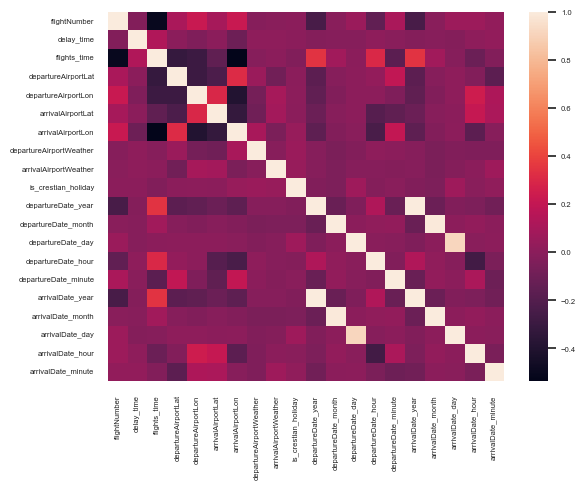

In [716]:
sns.heatmap(flights_df.corr())

we can see that there is no correlation between out columns to flight delay.
We thing that if we change out date presentation we maby can see some corelation

We will use date in year instad of our current way that use 3 separate columns

## Change Date presentatuin

In [717]:
def dayes_in_month(month,year):
    return calendar.monthrange(year, month)[1]

In [718]:
def get_day_in_year(year,mnt : pd.Series,day):
    daysList = []
    for i,x in enumerate(mnt.tolist()):
        days=0
        y = year.tolist()[i]
        for m in range(1,mnt.tolist()[i]):
            days = days + dayes_in_month(m,y)
        days = days + day.tolist()[i]
        daysList.append(days)
    return pd.Series(daysList)



In [719]:
def convert_days_columns_to_day_in_year(df,col):
    df[col + '_day_in_year'] = get_day_in_year(df[col+'_year'],df[col+'_month'],df[col+'_day'])

    # df = df.drop(col+'_month',axis = 1)
    # df = df.drop(col+'_day',axis = 1)

    return df

In [720]:
def convert_all_days_columns_to_day_in_year(df):
    df = convert_days_columns_to_day_in_year(df,'departureDate')
    df = convert_days_columns_to_day_in_year(df,'arrivalDate')
    return df

In [721]:
flights_df = convert_all_days_columns_to_day_in_year(flights_df)

Now we check if there is any correlation

<AxesSubplot:>

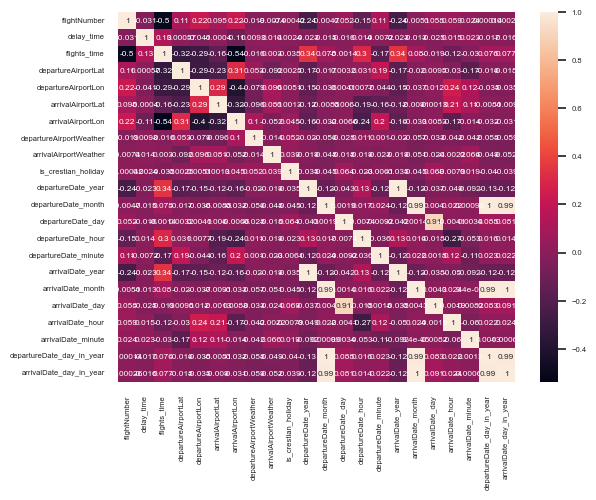

In [722]:
sns.heatmap(flights_df.corr(),annot=True)

# Data Visualization

Scatter plot

In [723]:
# pd.plotting.scatter_matrix(flights_df, figsize=(10, 10), diagonal='kde')
# plt.show()

## FLights count per year

<AxesSubplot:xlabel='departureDate_year', ylabel='count'>

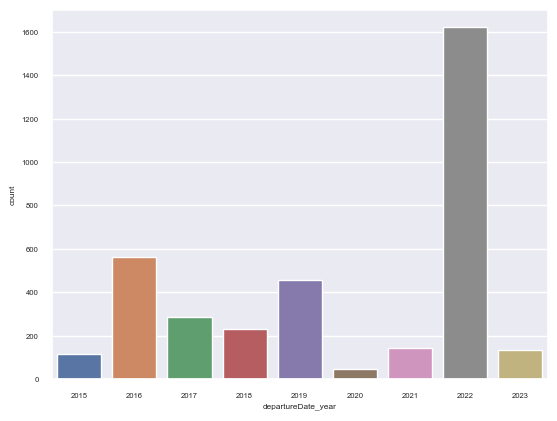

In [724]:
sns.countplot(data = flights_df , x='departureDate_year')

we can see that in 2020 and 2021 the number of flights was segnificantly lower then other years,
we can guess that happend due to covid 19 pandemics.
To avoid this pandemic from affect out model we will drop data from thouse years.

## Flights count per aircraft

<AxesSubplot:xlabel='tailnumber', ylabel='count'>

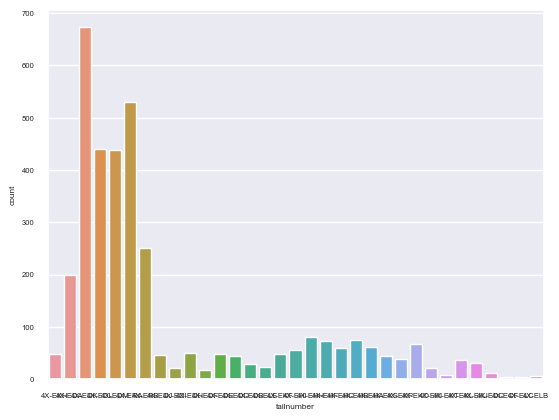

In [725]:
sns.set(font_scale=0.5)
sns.countplot(data = flights_df , x='tailnumber')

## Delay time per aircraft

<AxesSubplot:xlabel='tailnumber', ylabel='delay_time'>

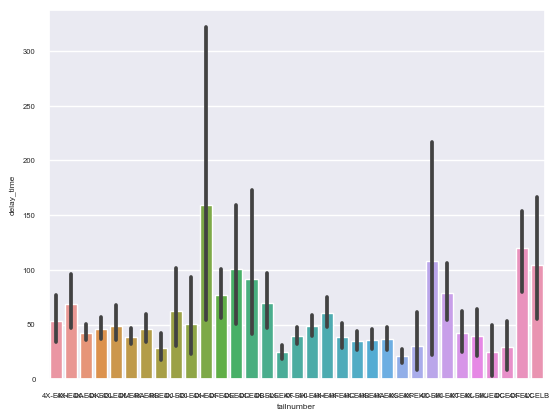

In [726]:
sns.barplot(data = flights_df,x = 'tailnumber', y = 'delay_time')

## Avarage delay time per year

<AxesSubplot:xlabel='departureDate_year', ylabel='delay_time'>

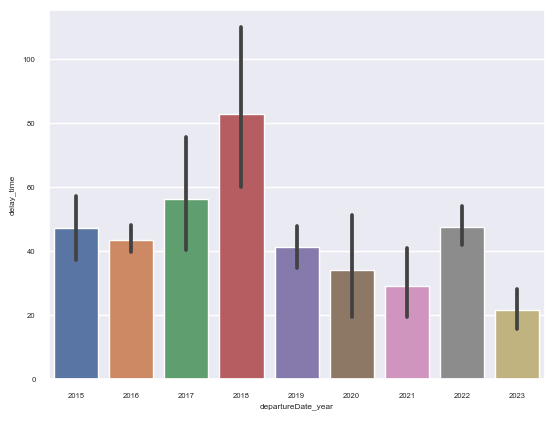

In [727]:
sns.barplot(data = flights_df , x='departureDate_year',y='delay_time')

## Delays per day in the year

We want to see if there is some connection between the day in the year and the delay time

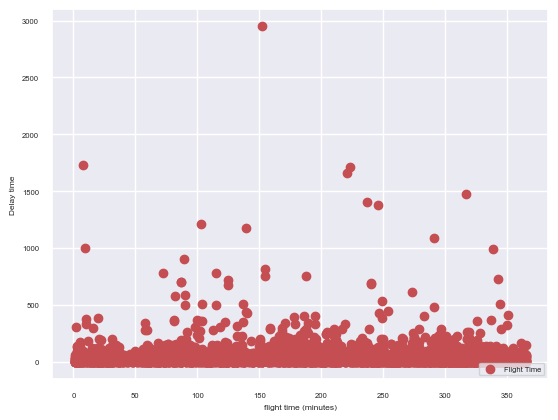

In [728]:
plt.scatter(x=flights_df['departureDate_day_in_year'],y=flights_df['delay_time'],c='r',label='Flight Time')
#plt.scatter(x=flights_df['Newspaper'],y=flights_df['delay_time'],c='k',marker='*',label='')
plt.legend(numpoints=1,loc=4)
plt.xlabel('flight time (minutes)')
plt.ylabel('Delay time')
plt.show()

## View the correlation between flight time to delay time

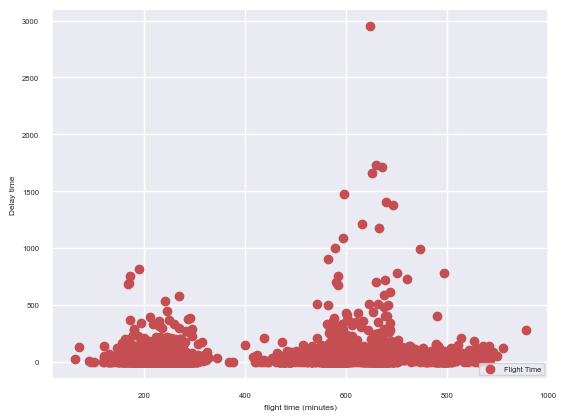

In [729]:
plt.scatter(x=flights_df['flights_time'],y=flights_df['delay_time'],c='r',label='Flight Time')
#plt.scatter(x=flights_df['Newspaper'],y=flights_df['delay_time'],c='k',marker='*',label='')
plt.legend(numpoints=1,loc=4)
plt.xlabel('flight time (minutes)')
plt.ylabel('Delay time')
plt.show()

# Manage outlayers


In [730]:
flights_df.describe()

,flightNumber,delay_time,flights_time,departureAirportLat,departureAirportLon,arrivalAirportLat,arrivalAirportLon,departureAirportWeather,arrivalAirportWeather,is_crestian_holiday,...,departureDate_day,departureDate_hour,departureDate_minute,arrivalDate_year,arrivalDate_month,arrivalDate_day,arrivalDate_hour,arrivalDate_minute,departureDate_day_in_year,arrivalDate_day_in_year
count,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,...,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000,3595.000000
mean,278.229485,47.293463,423.587761,37.118116,4.627483,36.613084,5.642062,7.457858,7.613908,0.012796,...,16.137413,13.296245,19.936022,2019.777191,6.812517,16.046175,11.214465,26.382476,192.249235,192.143255
std,452.704723,116.504651,217.120621,10.210313,46.710548,10.037570,46.985247,17.500110,17.785090,0.112407,...,9.145064,6.952448,17.049596,2.555806,3.452743,9.156956,5.917952,18.621296,105.472708,105.528035
min,1.000000,0.000000,62.000000,-26.132664,-122.389880,-26.132664,-122.389880,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,26.000000,3.000000,237.000000,32.000454,-0.453566,32.000454,-0.453566,0.000000,0.000000,0.000000,...,8.000000,7.000000,0.000000,2017.000000,4.000000,8.000000,8.000000,10.000000,101.000000,101.000000
50%,316.000000,18.000000,285.000000,32.000454,34.870743,32.000454,34.870743,1.000000,1.000000,0.000000,...,16.000000,14.000000,20.000000,2021.000000,7.000000,16.000000,11.000000,25.000000,195.000000,195.000000
75%,327.000000,52.000000,640.500000,43.681583,34.870743,41.794594,34.870743,2.000000,2.000000,0.000000,...,24.000000,20.000000,30.000000,2022.000000,10.000000,24.000000,15.000000,45.000000,288.500000,288.500000
max,5166.000000,2951.000000,956.000000,52.309070,126.451230,52.370277,121.799805,73.000000,75.000000,1.000000,...,31.000000,23.000000,55.000000,2023.000000,12.000000,31.000000,23.000000,55.000000,365.000000,365.000000


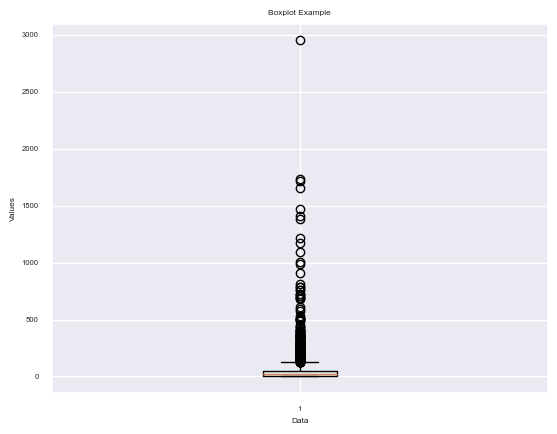

In [731]:
# Create a figure and axis
fig, ax = plt.subplots()

# Create a boxplot
ax.boxplot(flights_df['delay_time'])

# Add labels and title
ax.set_xlabel('Data')
ax.set_ylabel('Values')
ax.set_title('Boxplot Example')

# Show the plot
plt.show()

In [732]:
Q1 = np.percentile(flights_df["delay_time"], 25)
Q3 = np.percentile(flights_df["delay_time"], 75)
IQR = Q3 - Q1

flights_df = flights_df[(flights_df["delay_time"] > Q1 - 1.5*IQR) & (flights_df["delay_time"] < Q3 + 1.5*IQR )]

# Convert categprial string values to int

In [733]:
# def convert_categorials_to_bin(df , cols):
#     return pd.get_dummies( df,columns= cols)

In [734]:
# flights_df = convert_categorials_to_bin(flights_df,['departureAirportFsCode','arrivalAirportFsCode','tailnumber','aircraft_model','departureTerminal','arrivalTerminal'])

In [735]:
def transfer_str_to_numeric_vals(dataset,cols):

    for c in cols:
        dataset[c]=pd.factorize(dataset[c])[0]
    return dataset

In [736]:
flight_df = transfer_str_to_numeric_vals(flights_df,['departureAirportFsCode','arrivalAirportFsCode','tailnumber','aircraft_model','departureTerminal','arrivalTerminal'])

C:\Users\rongo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [737]:
flight_df = flights_df.dropna()

# Choosing Machine Lerning Model

We are trying to predict contineus value so we will choose Liniar regresion

## Build liniar regresion model

In [738]:
def train_liniar_reg_model(df,label):
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    X=df.drop(label,axis=1)
    y= df[label]

    x_scaled = x_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=42)
    lr_model = linear_model = LinearRegression()
    lr_model.fit(X_train, y_train)


    return x_scaler,y_scaler,lr_model,X_test,y_test
    

In [739]:
x_scaler,y_scaler,lr_model,X_test,y_test = train_liniar_reg_model(flight_df.dropna(),'delay_time')

## הערכץ ביצועים למודל ריגרסיה ליניארית

In [740]:
y_pred = lr_model.predict(X_test)
#y_pred = y_scaler.inverse_transform(y_pred)
#y_test = y_scaler.inverse_transform(y_test)
mse = mean_squared_error(y_test, y_pred)

In [741]:
mse

0.04691321089868836

In [742]:
def get_cross_val_score(df,label):
    x=df.drop(label,axis=1)
    y= df[label]
    return cross_val_score(lr_model, x, y, cv=5, scoring='r2').mean()
get_cross_val_score(flight_df,'delay_time')


0.08605568024448458

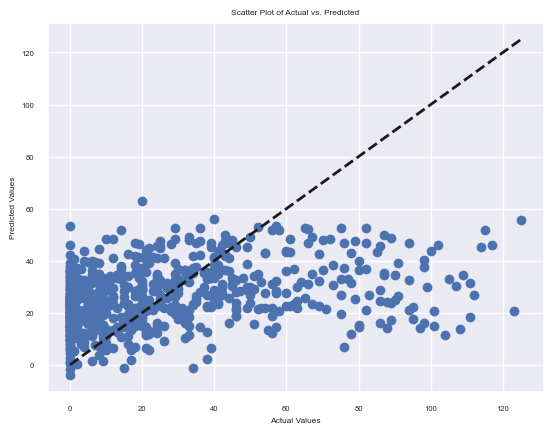

In [743]:
y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Regression line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs. Predicted')
plt.show()


# Try other models to improve our preformance

We can convert our problem to classification problem by convert "delay_time" column to binds
then use Random forest model

## Convert flight_delay to binds

we want to conver delay time to categorial value

first check the vlaues range of this value

In [744]:
flights_df['delay_time'].describe()

count    3314.000000
mean       26.023235
std        29.308682
min         0.000000
25%         2.000000
50%        15.000000
75%        41.000000
max       125.000000
Name: delay_time, dtype: float64

we can see that the range is 0 to 125 minutes

we split the values to parsts of 25 minutes
0-24,
25-49,
50-74,
75-99,
100-124,
125-149

In [745]:
flight_df.head()

,flightNumber,departureAirportFsCode,arrivalAirportFsCode,delay_time,aircraft_model,tailnumber,flights_time,departureTerminal,arrivalTerminal,departureAirportLat,...,departureDate_day,departureDate_hour,departureDate_minute,arrivalDate_year,arrivalDate_month,arrivalDate_day,arrivalDate_hour,arrivalDate_minute,departureDate_day_in_year,arrivalDate_day_in_year
0,381,0,0,22,0,0,204,0,0,32.000454,...,24,4,45,2016,6,24,9,0,176,176
1,382,1,1,20,1,0,213,1,1,45.627403,...,24,10,5,2016,6,24,13,55,176,176
2,553,0,2,0,0,0,133,0,2,32.000454,...,25,18,30,2016,6,25,21,15,177,177
3,554,2,1,29,0,0,137,2,1,42.688343,...,25,22,15,2016,6,26,0,40,177,178
6,345,0,3,17,0,0,250,0,3,32.000454,...,28,3,20,2016,6,28,7,55,180,180


In [746]:
def convert_col_to_bins(df,col):
    bin_edges = [-1, 25, 50, 75,100,125,150,175]
    labels = [1,2,3,4,5,6,7]
    df[col]= pd.cut(df[col], bins=bin_edges, labels=labels)
    return df

flight_df = convert_col_to_bins(flight_df,'delay_time')


In [747]:
flight_df.head()

,flightNumber,departureAirportFsCode,arrivalAirportFsCode,delay_time,aircraft_model,tailnumber,flights_time,departureTerminal,arrivalTerminal,departureAirportLat,...,departureDate_day,departureDate_hour,departureDate_minute,arrivalDate_year,arrivalDate_month,arrivalDate_day,arrivalDate_hour,arrivalDate_minute,departureDate_day_in_year,arrivalDate_day_in_year
0,381,0,0,1,0,0,204,0,0,32.000454,...,24,4,45,2016,6,24,9,0,176,176
1,382,1,1,1,1,0,213,1,1,45.627403,...,24,10,5,2016,6,24,13,55,176,176
2,553,0,2,1,0,0,133,0,2,32.000454,...,25,18,30,2016,6,25,21,15,177,177
3,554,2,1,2,0,0,137,2,1,42.688343,...,25,22,15,2016,6,26,0,40,177,178
6,345,0,3,1,0,0,250,0,3,32.000454,...,28,3,20,2016,6,28,7,55,180,180


## Build Random forest mpdel

In [748]:
flight_df[flight_df.delay_time.isnull()]

,flightNumber,departureAirportFsCode,arrivalAirportFsCode,delay_time,aircraft_model,tailnumber,flights_time,departureTerminal,arrivalTerminal,departureAirportLat,...,departureDate_day,departureDate_hour,departureDate_minute,arrivalDate_year,arrivalDate_month,arrivalDate_day,arrivalDate_hour,arrivalDate_minute,departureDate_day_in_year,arrivalDate_day_in_year


In [777]:
def train_random_forest_tree_model(df,label):
    X = df.drop(label,axis=1)
    y= df[label]

    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    x_scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf_model = RandomForestClassifier(n_estimators=3, random_state=40)
    rf_model.fit(X_train, y_train)
    return y_train,X_train,y_test,rf_model
    

In [778]:
rf_y_train,rf_X_train, rf_y_test,rf_model = train_random_forest_tree_model(flight_df,'delay_time')

## הערכת ביצועים למודל random forest

In [779]:
y_pred_train = rf_model.predict(rf_X_train)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = rf_y_train, y_pred = y_pred_train))

rf_y_pred = rf_model.predict(X_test)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = rf_y_test, y_pred = rf_y_pred))

Accuracy on training data=  0.9758581667295361
Accuracy on test data=  0.6138763197586727


C:\Users\rongo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


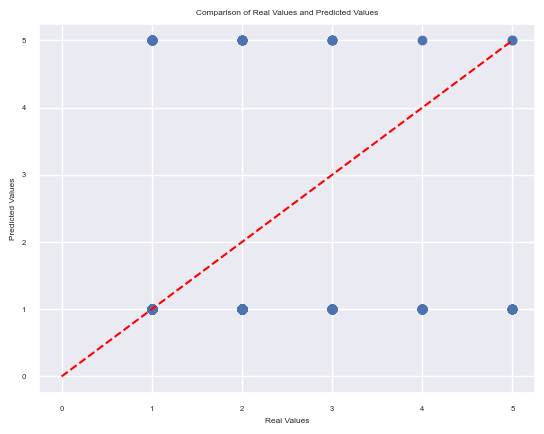

In [753]:
plt.scatter(rf_y_test, rf_y_pred)

plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.title('Comparison of Real Values and Predicted Values')

# Add a diagonal line for reference
max_value = max(np.max(rf_y_test), np.max(rf_y_pred))
plt.plot([0, max_value], [0, max_value], color='red', linestyle='--')

# Show the plot
plt.show()

# Compare between 2 models